# Cryptographic Analysis using CPA

In this assignment, we will analyze pre-recorded power traces to extract secret cryptographic key using Correlation Power Analysis (CPA).

The power traces were collected from an FPGA which implemented the cryptographic function:
$$
f(p,k) = \text{SBOX}(p\oplus k), p,k\in \mathbb{Z}_{16}
$$

The output of this function is sampled using Flip-Flops.

### Reading the data, and importing the SBOX

In [338]:
import mat73

# Load the plaintext adn power traces
PLAINTEXT = mat73.loadmat('inputs.mat')['plain']
POWER_TRACES = mat73.loadmat('cmos_exper.mat')['Imat']

# We translated the SBOX to python instead of dealing with matlab engine - seemed easier
SBOX4 = (12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7 ,1 , 2)

In [339]:
SYMBOL_WIDTH = 4
POSSIBLE_KEYS = [*range(2 ** SYMBOL_WIDTH)]

def hamming_weight(value: int) -> int:
    assert 0 <= value < 2 ** SYMBOL_WIDTH, f"{value} is not a symbol in our problem"
    return sum([((value & (1 << i)) != 0) for i in range(SYMBOL_WIDTH)])

def hamming_distance(a: int, b: int) -> int:
    return hamming_weight(a ^ b)


In [340]:
import numpy as np
from matplotlib import pyplot as plt


def calc_poi_values(plaintext: list) -> list[list[int]]:
    res = []
    for item in plaintext:
        res.append([SBOX4[int(item) ^ key] for key in POSSIBLE_KEYS])
    return res


def calc_poi_power_hw(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    for row in poi_values:
        res.append([hamming_weight(item) for item in row])
    return res


def calc_poi_power_hd(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    last_row = [0] * len(poi_values[0])
    for row in poi_values:
        res.append([hamming_distance(item, last_row[i]) for i, item in enumerate(row)])
        last_row = row
    return res


def calculate_correlation_matrix(h, t):
    # Center the matrices by subtracting their means
    h_centered = h - np.mean(h, axis=0, keepdims=True)
    t_centered = t - np.mean(t, axis=0, keepdims=True)

    # Calculate covariance
    cov = h_centered.T @ t_centered

    # Calculate standard deviations
    sigma_h = np.sqrt(np.sum(h_centered**2, axis=0))
    sigma_t = np.sqrt(np.sum(t_centered**2, axis=0))

    # Calculate correlation coefficients
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    corr_matrix = cov / (np.outer(sigma_h, sigma_t) + epsilon)

    return corr_matrix


# mat_hw = (
#     calculate_correlation_matrix(
#         calc_poi_power_hw(calc_poi_values(PLAINTEXT)), POWER_TRACES
#     ),
# )[0]

mat_hd = (
    calculate_correlation_matrix(
        calc_poi_power_hd(calc_poi_values(PLAINTEXT)), POWER_TRACES
    ),
)[0]

mat_val = calculate_correlation_matrix(calc_poi_values(PLAINTEXT), POWER_TRACES)

Now let us create some functions to plot all these graphs:

In [341]:
def maximum_correlation_vs_key_guess_plot(mat: list[list[int]], label: str):
    plt.plot(range(len(mat_val)), [max(np.abs(row)) for row in mat])
    plt.xlabel("Key guess")
    plt.ylabel("Maximum Correlation coefficient")
    plt.title("Maximum Correlation coefficient vs. key guess for " + label + " metric")


def correlation_coefficient_vs_sample_for_all_key_guesses_plot(
    mat: list[list[int]], label: str
):
    """
    Show it as a imshow
    """
    lines = []
    for i, row in enumerate(mat):
        lines.append(plt.plot(range(len(row)), row, label=f"key={i}"))
    plt.legend()
    plt.xlabel("Sample (time)")
    plt.ylabel("Correlation coefficient")
    plt.title(
        "Correlation coefficient vs. sample (time) for all key guesses for "
        + label
        + " metric"
    )


def correlation_coefficient_vs_trace_num_for_all_keys(
    model: list[list[int]], label: str
):
    max_correlation = [[] for _ in range(len(POSSIBLE_KEYS))]
    for i in range(len(POWER_TRACES)):
        mat = (
            calculate_correlation_matrix(
                model[:(i+1)],
                POWER_TRACES[:(i+1)],
            ),
        )[0]
        for j in range(len(max_correlation)):
            max_correlation[j].append(max(np.abs(mat[j])))

    lines = []
    for i, row in enumerate(max_correlation):
        lines.append(plt.plot(range(len(row)), row, label=f"key={i}"))
    plt.legend()
    plt.xlabel("Number of traces")
    plt.ylabel("Max correlation coefficient")
    plt.title(
        "Correlation coefficient vs. number of traces for all key guesses "
        + label
        + " metric"
    )

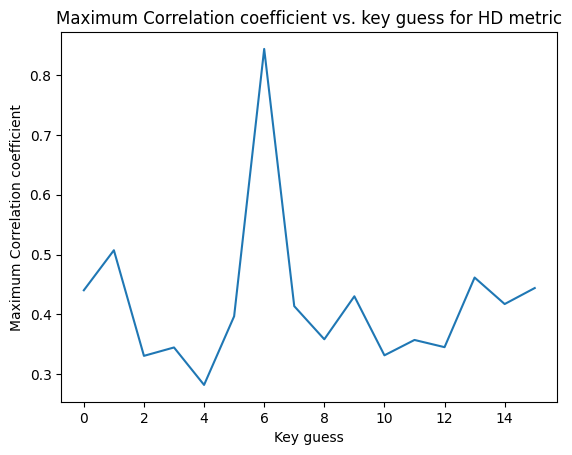

In [342]:
maximum_correlation_vs_key_guess_plot(mat_hd, "HD")

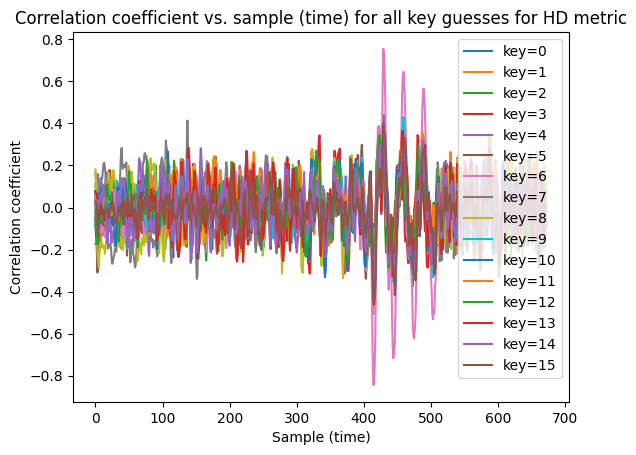

In [343]:
correlation_coefficient_vs_sample_for_all_key_guesses_plot(mat_hd, "HD")

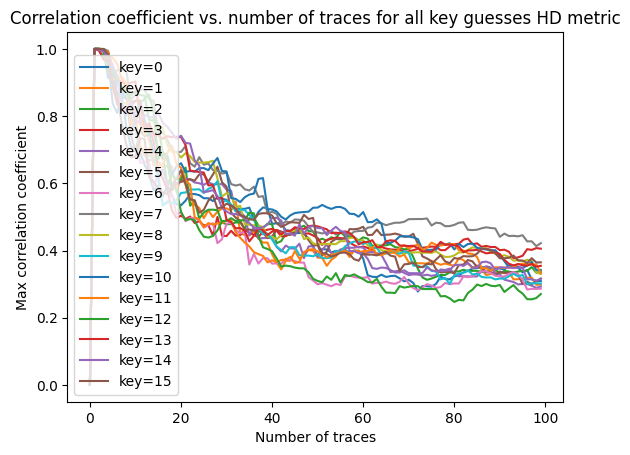

In [ ]:
correlation_coefficient_vs_trace_num_for_all_keys(calc_poi_power_hd(calc_poi_values(PLAINTEXT)), "HD")